In [12]:
import pandas as pd
import regex as re
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.optimize import curve_fit
import statsmodels.api as sm


In [13]:
data_root = '../Documents/MiscProjects/meg_fiber_data/'
video_file = 'MJ25_1 full edited.csv'
fiber_file = 'mj25_1_session62025-04-16T08_44_18.csv'

In [ ]:
date_match = re.match(r'([a-z]+\d+).*\d{1}(\d{4})-(\d{2})-(\d{2}).*', fiber_file)

mouse = date_match[1]
year = date_match[2]
month = date_match[3]
day = date_match[4]

# comment

date = pd.Timestamp(f'{year}-{month}-{day}')

Timestamp('2025-04-16 00:00:00')

In [15]:
fiber_df = pd.read_csv(data_root + fiber_file)
initial_time = fiber_df['ComputerTimestamp'].iloc[0]
fiber_df['AbsoluteTimestamp'] = fiber_df['ComputerTimestamp'].apply(lambda ms: date + pd.Timedelta(milliseconds=ms))

initial_event_time = fiber_df['AbsoluteTimestamp'].iloc[0]

fiber_df.head()

,FrameCounter,SystemTimestamp,LedState,ComputerTimestamp,G0,AbsoluteTimestamp
0,0,681.712544,7,3.145870e+07,0.003922,2025-04-16 08:44:18.696115200
1,1,681.729184,2,3.145871e+07,0.024448,2025-04-16 08:44:18.712691200
2,2,681.745856,1,3.145873e+07,0.028378,2025-04-16 08:44:18.729651200
3,3,681.762528,2,3.145875e+07,0.022378,2025-04-16 08:44:18.746483200
4,4,681.779168,1,3.145876e+07,0.026272,2025-04-16 08:44:18.762969600


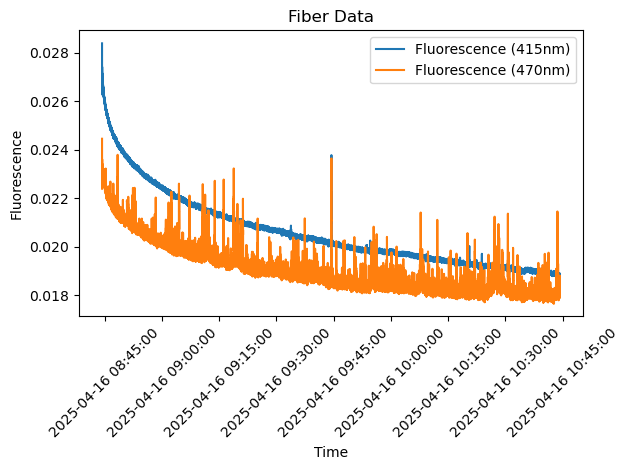

In [16]:
def plot_fiber_data(df):
  led_states = [[1, "Fluorescence (415nm)"], [2, "Fluorescence (470nm)"]]

  for [led_state, label] in led_states:
    subset = df[df['LedState'] == led_state]
    plt.plot(subset['AbsoluteTimestamp'], subset['G0'], label=label)
  plt.title('Fiber Data')
  plt.xlabel('Time')
  plt.ylabel('Fluorescence')
  plt.legend()
  plt.xticks(rotation=45)
  plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))
  plt.tight_layout()
  plt.show()


plot_fiber_data(fiber_df)

In [17]:
video_df = pd.read_csv(data_root + video_file)
video_df.drop(columns=['Unnamed: 3'], inplace=True)

# Add id column containing column number at the start of the dataframe
video_df.insert(0, 'id', range(len(video_df)))

video_df['AbsoluteTimestamp'] = video_df['Aligned to fibre start'].apply(
  lambda s: initial_event_time + pd.Timedelta(seconds=s))

window_size_seconds = 10

video_df['window_start'] = video_df['AbsoluteTimestamp'] - pd.Timedelta(seconds=window_size_seconds / 2)
video_df['window_end'] = video_df['AbsoluteTimestamp'] + pd.Timedelta(seconds=window_size_seconds / 2)

video_df.head()

,id,Event Type,Start Time,End Time,Aligned to fibre start,End Aligned,AbsoluteTimestamp,window_start,window_end
0,0,Box sniff,112.214255,NaN,45.214255,NaN,2025-04-16 08:45:03.910370200,2025-04-16 08:44:58.910370200,2025-04-16 08:45:08.910370200
1,1,Box sniff,258.983377,NaN,191.983377,NaN,2025-04-16 08:47:30.679492200,2025-04-16 08:47:25.679492200,2025-04-16 08:47:35.679492200
2,2,Box sniff,269.215986,NaN,202.215986,NaN,2025-04-16 08:47:40.912101200,2025-04-16 08:47:35.912101200,2025-04-16 08:47:45.912101200
3,3,Nose poke into aperture,275.229416,NaN,208.229416,NaN,2025-04-16 08:47:46.925531200,2025-04-16 08:47:41.925531200,2025-04-16 08:47:51.925531200
4,4,Nose poke into aperture,396.807895,NaN,329.807895,NaN,2025-04-16 08:49:48.504010200,2025-04-16 08:49:43.504010200,2025-04-16 08:49:53.504010200


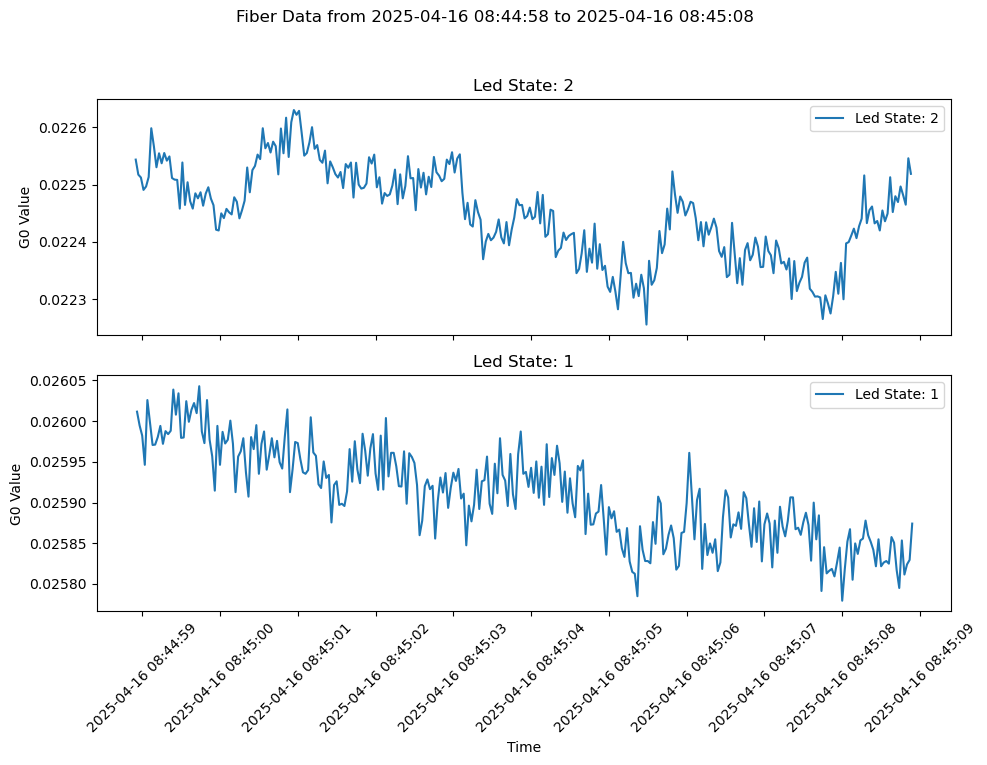

<Figure size 640x480 with 0 Axes>

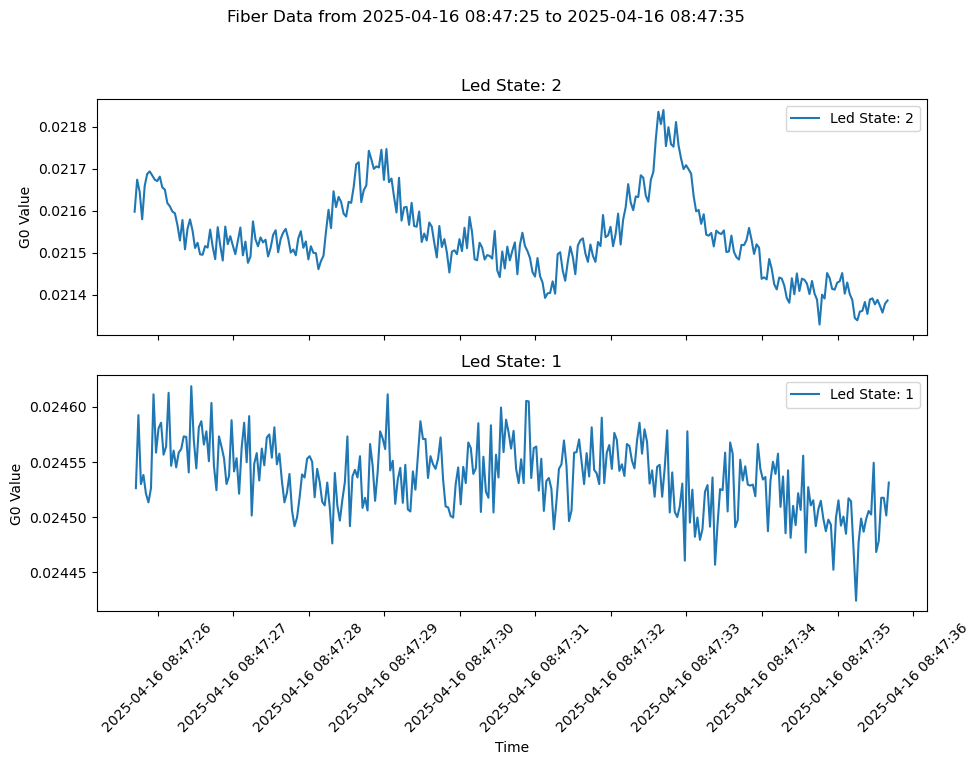

<Figure size 640x480 with 0 Axes>

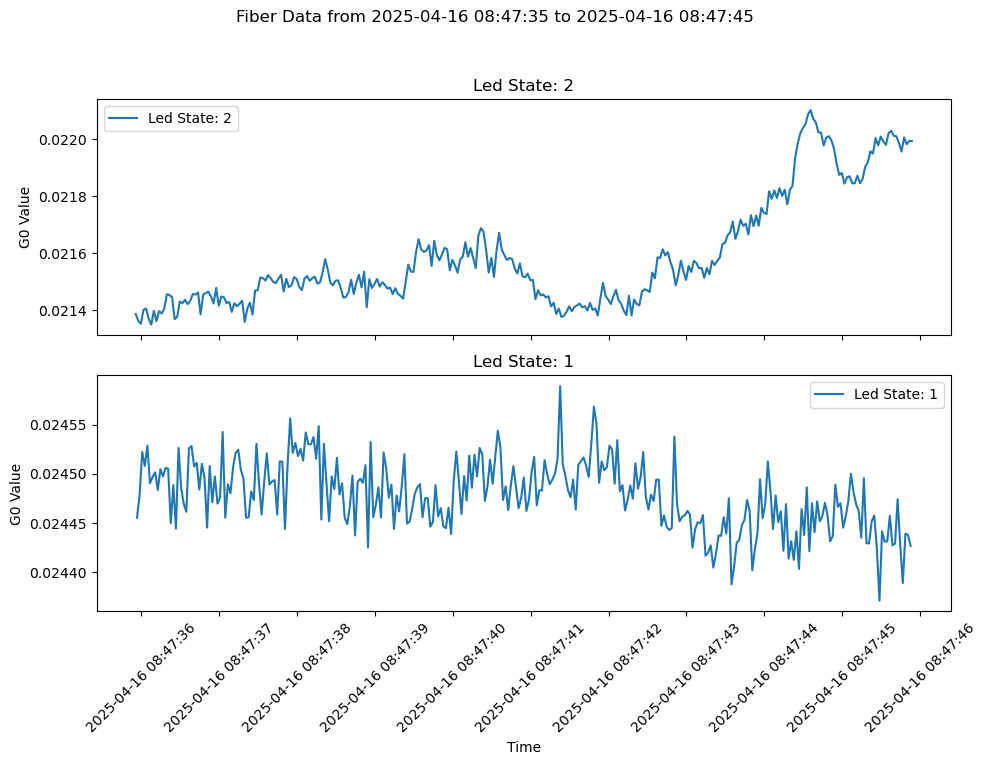

<Figure size 640x480 with 0 Axes>

In [18]:
# For each row in video_df, create a plot of the fiber_df data within the window defined by window_start and window_end, with each Led State on a separate sub

def plot_fiber_data_in_window(row):
  window_start = row['window_start']
  window_end = row['window_end']

  filtered_fiber_df = fiber_df[
    (fiber_df['AbsoluteTimestamp'] >= window_start) & (fiber_df['AbsoluteTimestamp'] <= window_end)]

  if filtered_fiber_df.empty:
    return None

  led_states = filtered_fiber_df['LedState'].unique()
  n_leds = len(led_states)
  fig, axes = plt.subplots(n_leds, 1, figsize=(10, 4 * n_leds), sharex=True)

  if n_leds == 1:
    axes = [axes]

  for ax, led_state in zip(axes, led_states):
    led_data = filtered_fiber_df[filtered_fiber_df['LedState'] == led_state]
    ax.plot(led_data['AbsoluteTimestamp'], led_data['G0'], label=f'Led State: {led_state}')
    ax.set_title(f'Led State: {led_state}')
    ax.set_ylabel('G0 Value')
    ax.legend()
    ax.tick_params(axis='x', rotation=45)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))

  axes[-1].set_xlabel('Time')
  start_str = window_start.strftime('%Y-%m-%d %H:%M:%S')
  end_str = window_end.strftime('%Y-%m-%d %H:%M:%S')
  fig.suptitle(f'Fiber Data from {start_str} to {end_str}')
  plt.tight_layout(rect=(0.0, 0.03, 1.0, 0.95))
  plt.show()
  return plt.clf()  # Clear the figure for the next plot

# Apply the function to each row in video_df
for index, data_row in video_df.head(3).iterrows():
  plot_fiber_data_in_window(data_row)
  plt.pause(0.1)  # Pause to allow the plot to render before moving to the next

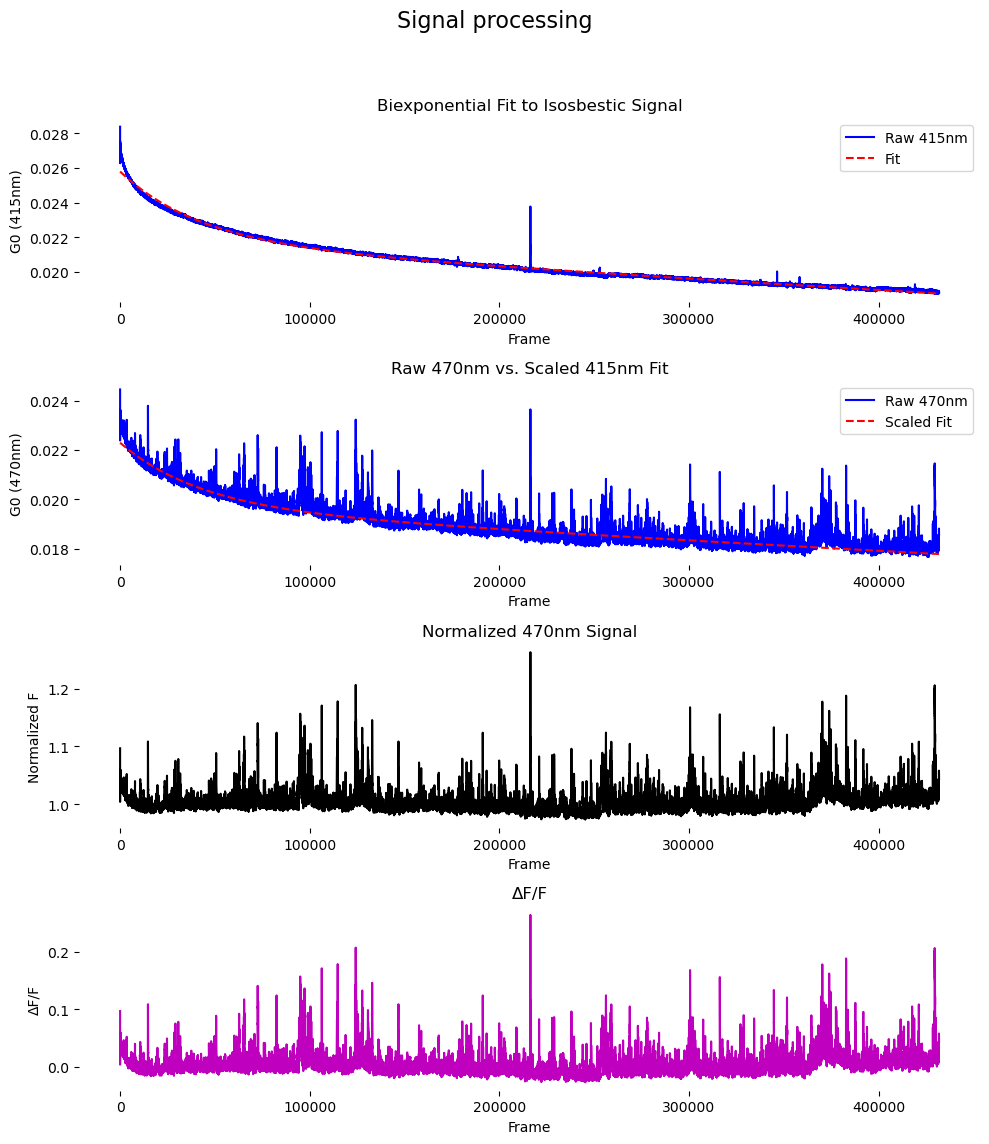

,FrameCounter,SystemTimestamp,LedState,ComputerTimestamp,G0,AbsoluteTimestamp,Normalized,DeltaF_F
1,1,681.729184,2,3.145871e+07,0.024448,2025-04-16 08:44:18.712691200,1.096864,0.096864
3,3,681.762528,2,3.145875e+07,0.022378,2025-04-16 08:44:18.746483200,1.003990,0.003990
5,5,681.795840,2,3.145878e+07,0.024332,2025-04-16 08:44:18.779340800,1.091658,0.091658
7,7,681.829184,2,3.145881e+07,0.024262,2025-04-16 08:44:18.812697600,1.088528,0.088528
9,9,681.862496,2,3.145885e+07,0.024233,2025-04-16 08:44:18.846169600,1.087255,0.087255


In [19]:
def biexp(x, a, b, c, d):
  """Match MATLAB's exp2 model: a*exp(b*x) + c*exp(d*x) with overflow protection"""
  # Scale x to prevent overflow in exponentials
  x_scaled = x / np.max(x) if np.max(np.abs(x)) > 0 else x
  # Adjust the rate parameters to compensate for scaling
  b_scaled = b * np.max(x) if np.max(np.abs(x)) > 0 else b
  d_scaled = d * np.max(x) if np.max(np.abs(x)) > 0 else d
  return a * np.exp(b_scaled * x_scaled) + c * np.exp(d_scaled * x_scaled)


def pre_process_data():
  # Extract 415nm signal - similar to MATLAB
  isosbestic_data = fiber_df.loc[fiber_df['LedState'] == 1, 'G0'].values
  isosbestic_frame = fiber_df.loc[fiber_df['LedState'] == 1, 'FrameCounter'].values

  # Better initial guesses to avoid overflow
  p0 = [max(isosbestic_data) / 2, -0.0001, max(isosbestic_data) / 2, -0.00001]

  # Apply bounds to prevent extreme parameter values
  bounds = ([0, -np.inf, 0, -np.inf], [np.inf, 0, np.inf, 0])

  popt, pcov = curve_fit(biexp, isosbestic_frame, isosbestic_data,
                         p0=p0, maxfev=10000, bounds=bounds)

  # Extract 470nm signal - similar to MATLAB
  dLight_data = fiber_df.loc[fiber_df['LedState'] == 2, 'G0'].values
  dLight_frame = fiber_df.loc[fiber_df['LedState'] == 2, 'FrameCounter'].values

  # Evaluate fit at dLight frames - same as MATLAB approach
  isosbestic_fit_at_470 = biexp(dLight_frame, *popt)

  # Robust fit - similar to MATLAB's robustfit with bisquare
  valid_mask = np.isfinite(dLight_data) & np.isfinite(isosbestic_fit_at_470)
  X = sm.add_constant(isosbestic_fit_at_470[valid_mask])
  robust_model = sm.RLM(dLight_data[valid_mask], X, M=sm.robust.norms.TukeyBiweight())
  robust_results = robust_model.fit()
  fit2 = robust_results.params

  # Scale fit to match 470nm data
  scaled_fit = isosbestic_fit_at_470 * fit2[1] + fit2[0]
  normalized_F = dLight_data / scaled_fit
  dF_F = (dLight_data - scaled_fit) / scaled_fit

  plt.figure(figsize=(10, 12))
  plt.suptitle(f'Signal processing', fontsize=16)

  # Panel 1: Biexponential fit
  plt.subplot(4, 1, 1)
  plt.plot(isosbestic_frame, isosbestic_data, 'b', label='Raw 415nm')
  plt.plot(isosbestic_frame, biexp(isosbestic_frame, *popt), 'r--', linewidth=1.5, label='Fit')
  plt.xlabel('Frame')
  plt.ylabel('G0 (415nm)')
  plt.title('Biexponential Fit to Isosbestic Signal')
  plt.legend()
  plt.grid(False)
  plt.box(False)

  # Panel 2: 470nm vs scaled fit
  plt.subplot(4, 1, 2)
  plt.plot(dLight_frame, dLight_data, 'b', label='Raw 470nm')
  plt.plot(dLight_frame, scaled_fit, 'r--', linewidth=1.5, label='Scaled Fit')
  plt.xlabel('Frame')
  plt.ylabel('G0 (470nm)')
  plt.title('Raw 470nm vs. Scaled 415nm Fit')
  plt.legend()
  plt.grid(False)
  plt.box(False)

  # Panel 3: Normalized F
  plt.subplot(4, 1, 3)
  plt.plot(dLight_frame, normalized_F, 'k')
  plt.xlabel('Frame')
  plt.ylabel('Normalized F')
  plt.title('Normalized 470nm Signal')
  plt.grid(False)
  plt.box(False)

  # Panel 4: ΔF/F
  plt.subplot(4, 1, 4)
  plt.plot(dLight_frame, dF_F, 'm')
  plt.xlabel('Frame')
  plt.ylabel('ΔF/F')
  plt.title('ΔF/F')
  plt.grid(False)
  plt.box(False)

  plt.tight_layout(rect=(0, 0.03, 1, 0.95))
  plt.show()

  return [normalized_F, dF_F]



[normalized, delta] = pre_process_data()

fiber_data_with_normalized = fiber_df[fiber_df['LedState'] == 2].copy()
fiber_data_with_normalized['Normalized'] = normalized
fiber_data_with_normalized['DeltaF_F'] = delta

fiber_data_with_normalized.head()


In [20]:
def plot_delta_f_for_row(row):
    window_start = row['window_start']
    window_end = row['window_end']
    event_type = row['Event Type']
    event_time = row['AbsoluteTimestamp']

    filtered_fiber_df = fiber_data_with_normalized[
        (fiber_data_with_normalized['AbsoluteTimestamp'] >= window_start) & (fiber_data_with_normalized['AbsoluteTimestamp'] <= window_end)]

    if filtered_fiber_df.empty:
        return None

    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot ΔF/F as the main metric
    ax.plot(filtered_fiber_df['AbsoluteTimestamp'], filtered_fiber_df['DeltaF_F'], 'm-',
            linewidth=2.5, label='ΔF/F', zorder=3)

    # Add baseline reference at y=0
    ax.axhline(y=0, color='gray', linestyle=':', alpha=0.7, label='Baseline')

    # Add event line
    ax.axvline(x=event_time, color='r', linestyle='-', linewidth=2, label='Event', zorder=4)

    # Set y limits with padding for better visualization
    delta_min = min(filtered_fiber_df['DeltaF_F'].min(), 0)
    delta_max = filtered_fiber_df['DeltaF_F'].max()
    y_padding = (delta_max - delta_min) * 0.2
    ax.set_ylim(delta_min - y_padding, delta_max + y_padding)

    # Format axes
    ax.set_xlabel('Time')
    ax.set_ylabel('ΔF/F', fontweight='bold')
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))
    ax.tick_params(axis='x', rotation=45)

    # Add grid and legend
    ax.grid(alpha=0.15)
    ax.legend(loc='upper left')

    fig.suptitle(f'{event_type} Fiber Data from {window_start.strftime("%Y-%m-%d %H:%M:%S")} to {window_end.strftime("%Y-%m-%d %H:%M:%S")}')
    fig.tight_layout()
    plt.show()

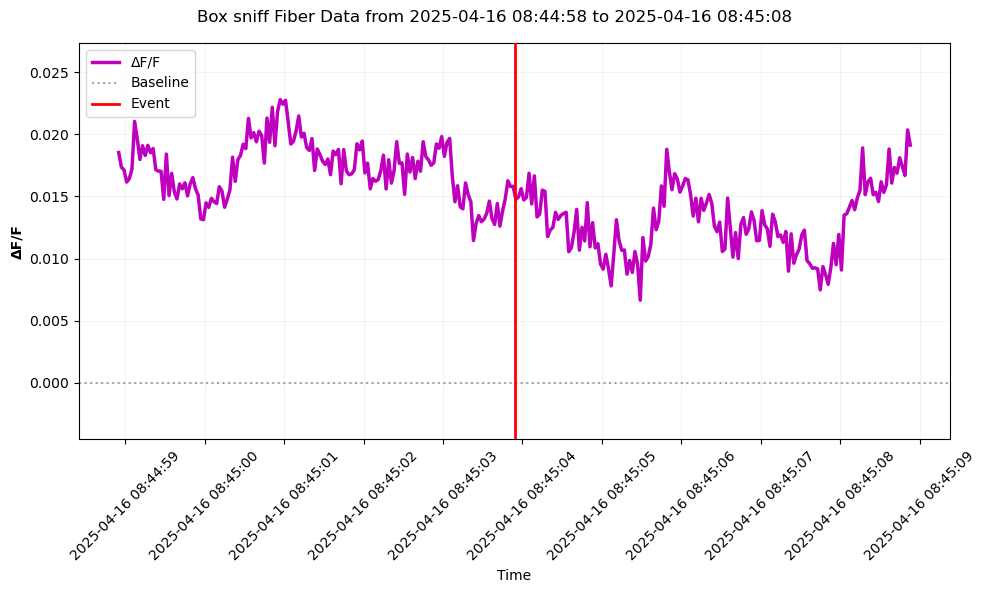

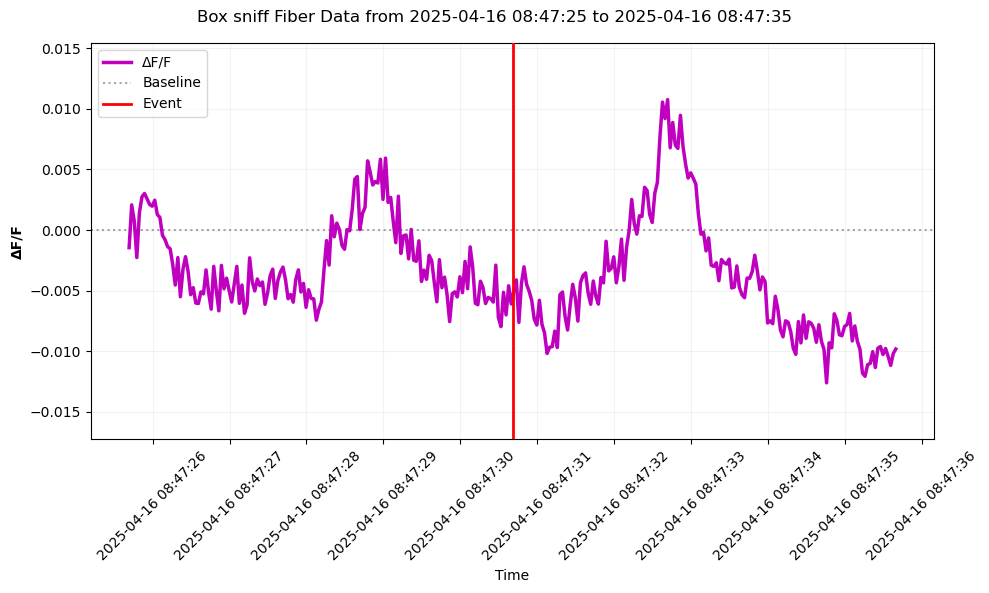

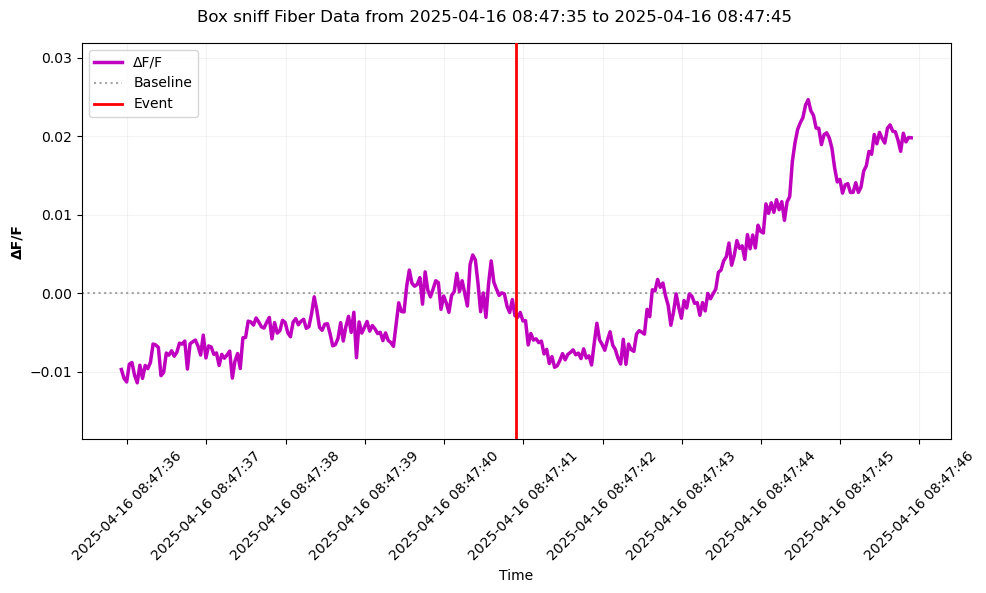

In [21]:
# Apply the function to first 10 rows in video_df
for index, data_row in video_df.head(3).iterrows():
    plot_delta_f_for_row(data_row)
    plt.pause(0.1)  # Pause to allow the plot to render before moving to the next

Processing event type: Box sniff (9 events)
Found 9 valid windows for Box sniff


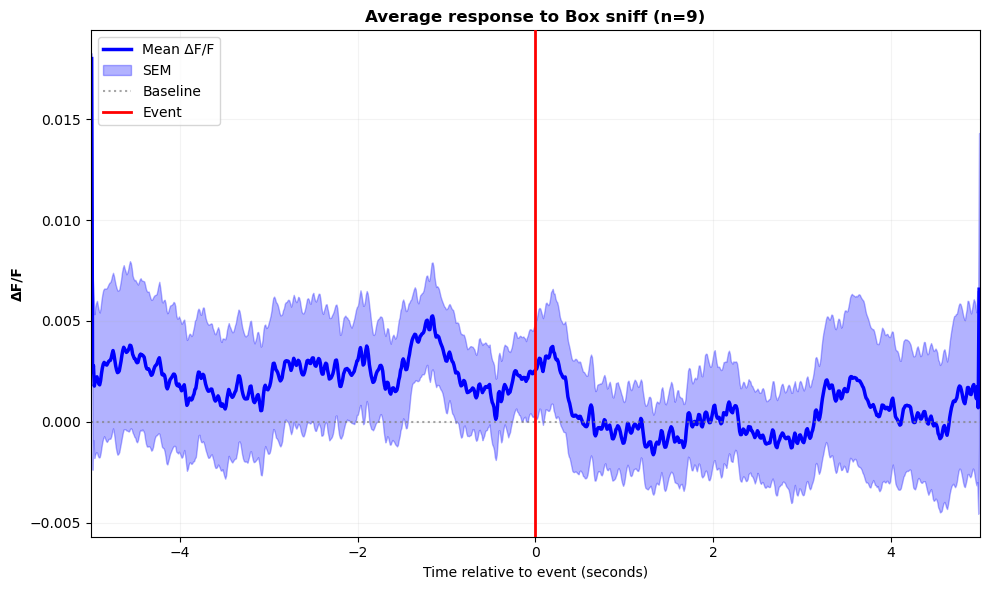

Processing event type: Nose poke into aperture (59 events)
Found 59 valid windows for Nose poke into aperture


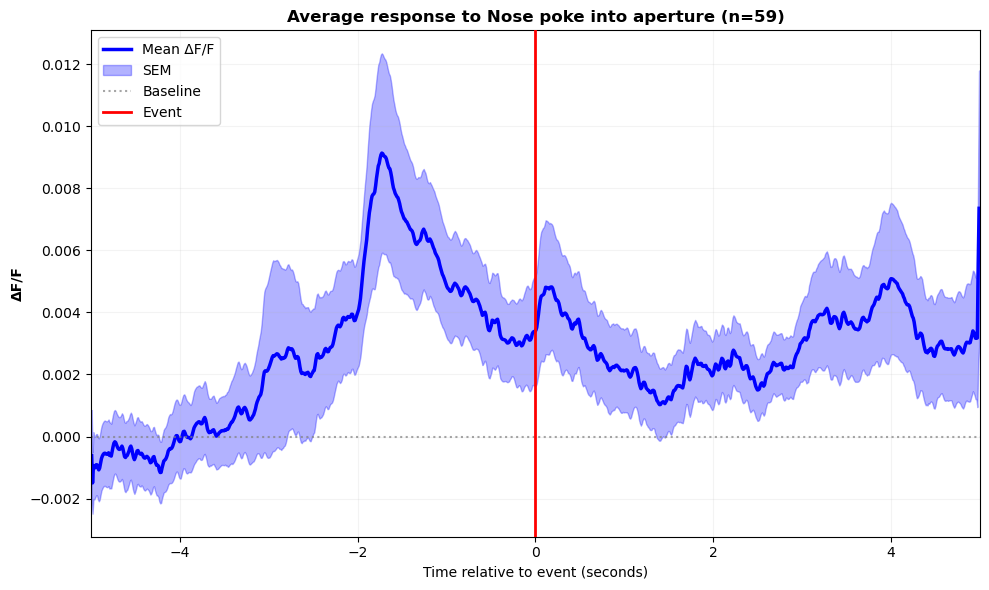

Processing event type: Bedding pull (38 events)
Found 38 valid windows for Bedding pull


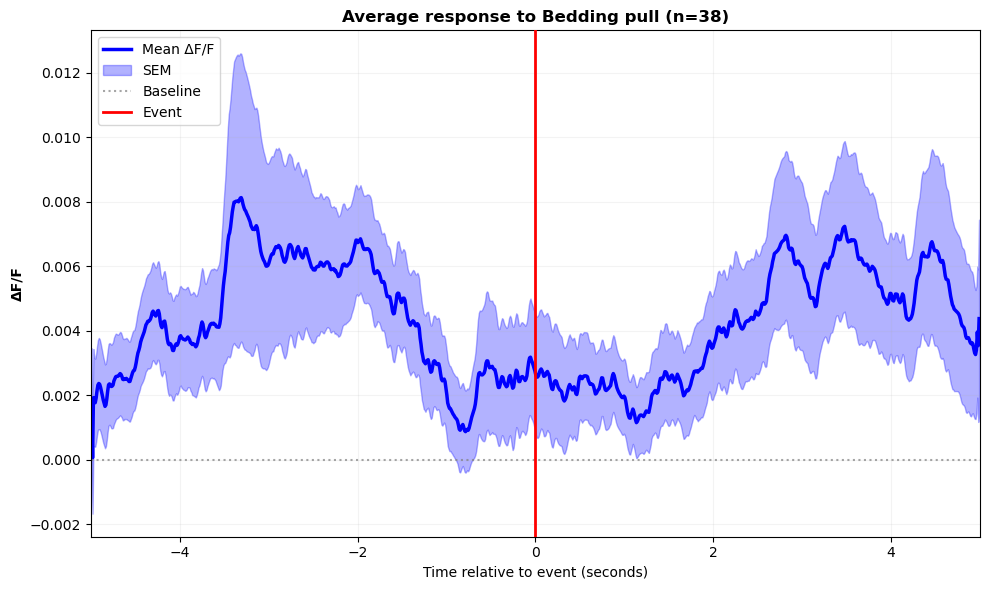

In [22]:
def plot_average_delta_f_by_event_type(video_df, fiber_data_with_normalized, window_size_seconds=10):
    # Get unique event types
    event_types = video_df['Event Type'].unique()

    # For each event type
    for event_type in event_types:
        # Get all rows for this event type
        event_rows = video_df[video_df['Event Type'] == event_type]

        print(f"Processing event type: {event_type} ({len(event_rows)} events)")

        # Initialize list to store aligned time series data
        all_time_series = []

        # Process each window for this event type
        for _, row in event_rows.iterrows():
            event_time = row['AbsoluteTimestamp']
            window_start = row['window_start']
            window_end = row['window_end']

            # Get fiber data within this window
            filtered_fiber_df = fiber_data_with_normalized[
                (fiber_data_with_normalized['AbsoluteTimestamp'] >= window_start) &
                (fiber_data_with_normalized['AbsoluteTimestamp'] <= window_end)]

            if not filtered_fiber_df.empty:
                # Convert timestamps to seconds relative to event time (0 = event time)
                relative_times = [(ts - event_time).total_seconds() for ts in filtered_fiber_df['AbsoluteTimestamp']]
                delta_f_values = filtered_fiber_df['DeltaF_F'].values

                # Only add if we have enough valid data points
                if len(relative_times) > 5:  # Require at least 5 data points
                    all_time_series.append((relative_times, delta_f_values))

        if not all_time_series:
            print(f"No valid data found for event type: {event_type}")
            continue

        print(f"Found {len(all_time_series)} valid windows for {event_type}")

        # Create a common time grid
        time_grid = np.linspace(-window_size_seconds/2, window_size_seconds/2, 1000)

        # Interpolate each time series onto the common grid
        interpolated_series = []
        for rel_times, delta_values in all_time_series:
            # Only interpolate within the actual range of data to avoid extrapolation
            min_time = max(-window_size_seconds/2, min(rel_times))
            max_time = min(window_size_seconds/2, max(rel_times))

            # Generate mask for valid interpolation range
            valid_mask = (time_grid >= min_time) & (time_grid <= max_time)

            # Initialize with all NaN
            interp_values = np.full_like(time_grid, np.nan)

            # Only interpolate within valid range
            interp_values[valid_mask] = np.interp(
                time_grid[valid_mask], rel_times, delta_values)

            interpolated_series.append(interp_values)

        # Convert to numpy array for calculations
        interpolated_array = np.array(interpolated_series)

        # Calculate number of valid values at each time point
        n_valid = np.sum(~np.isnan(interpolated_array), axis=0)

        # Require at least 2 valid values to compute statistics
        valid_times = n_valid >= 2

        if not np.any(valid_times):
            print(f"No time points have enough valid data for event type: {event_type}")
            continue

        # Filter time grid to only points with enough data
        filtered_time_grid = time_grid[valid_times]
        filtered_array = interpolated_array[:, valid_times]

        # Calculate statistics only on filtered data
        mean_delta_f = np.nanmean(filtered_array, axis=0)
        std_delta_f = np.nanstd(filtered_array, axis=0)
        sem_delta_f = std_delta_f / np.sqrt(n_valid[valid_times])

        # Create the plot
        fig, ax = plt.subplots(figsize=(10, 6))

        # Plot mean line
        ax.plot(filtered_time_grid, mean_delta_f, 'b-', linewidth=2.5, label='Mean ΔF/F')

        # Add shaded area for standard error
        ax.fill_between(filtered_time_grid,
                       mean_delta_f - sem_delta_f,
                       mean_delta_f + sem_delta_f,
                       alpha=0.3, color='b', label='SEM')

        # Add baseline and event lines
        ax.axhline(y=0, color='gray', linestyle=':', alpha=0.7, label='Baseline')
        ax.axvline(x=0, color='r', linestyle='-', linewidth=2, label='Event', zorder=4)

        # Format axes
        ax.set_xlabel('Time relative to event (seconds)')
        ax.set_ylabel('ΔF/F', fontweight='bold')
        ax.grid(alpha=0.15)
        ax.legend(loc='upper left')

        # Set x-axis limits to the original window size
        ax.set_xlim(-window_size_seconds/2, window_size_seconds/2)

        # Add title showing event type and number of traces
        n_traces = len(all_time_series)
        ax.set_title(f'Average response to {event_type} (n={n_traces})', fontweight='bold')

        fig.tight_layout()
        plt.show()

# Call the function to plot average ΔF/F by event type
plot_average_delta_f_by_event_type(video_df, fiber_data_with_normalized, window_size_seconds=10)